In [1]:
import numpy as np
import matplotlib.pyplot as plt

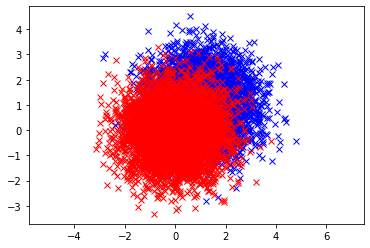

(10000, 2)
(10000, 1)


In [2]:
num_train = 5000
num_test = 1000

sig_mean = [1,1]
sig_cov = [[1,0],[0,1]]

bkg_mean = [0,0]
bkg_cov = [[1,0],[0,1]]

sig_data_train = np.random.multivariate_normal(sig_mean, sig_cov, num_train)
sig_labels_train = np.ones(len(sig_data_train))
bkg_data_train = np.random.multivariate_normal(bkg_mean, bkg_cov, num_train)
bkg_labels_train = np.zeros(len(bkg_data_train))
data_train = np.vstack((sig_data_train,bkg_data_train))
labels_train = np.hstack((sig_labels_train,bkg_labels_train)).reshape(-1,1)

sig_data_test = np.random.multivariate_normal(sig_mean, sig_cov, num_test)
sig_labels_test = np.ones(len(sig_data_test))
bkg_data_test = np.random.multivariate_normal(bkg_mean, bkg_cov, num_test)
bkg_labels_test = np.zeros(len(bkg_data_test))
data_test = np.vstack((sig_data_test,bkg_data_test))
labels_test = np.hstack((sig_labels_test,bkg_labels_test)).reshape(-1,1)

plt.plot(sig_data_train[:,0], sig_data_train[:,1], 'x',color='b')
plt.plot(bkg_data_train[:,0], bkg_data_train[:,1], 'x', color='r')
plt.axis('equal')
plt.show()

print(data_train.shape)
#print(data_train)
print(labels_train.shape)
#print(labels_train)

data = [data_train, labels_train, data_test, labels_test]

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class Net(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Net, self).__init__()
        self.hl_1 = nn.Linear(in_feats,hidden_feats)
        self.hl_2 = nn.Linear(hidden_feats,out_feats)
    def forward(self, input):
        layer_1 = F.relu(self.hl_1(input))
        output = F.sigmoid(self.hl_2(layer_1))
        return output

In [5]:
def train(model, data, epochs=20):
    X_train, y_train, X_test, y_test = data
    X_test = torch.from_numpy(np.float32(X_test))
    y_test = torch.from_numpy(np.float32(y_test))

    history = {'train_loss':[],'test_loss':[]}
    
    mini_batch_size = 64
    minibatches = int(X_train.shape[0]/mini_batch_size)
    allindices = np.arange(X_train.shape[0])
    np.random.shuffle(allindices)

    for e in range(epochs):
        model.train()
        for i in range(minibatches):
            indices = allindices[int(i*mini_batch_size):int((i+1)*mini_batch_size-1)]
            batch_data = torch.from_numpy(np.float32(X_train[indices])).to(device)
            batch_labels = torch.from_numpy(np.float32(y_train[indices])).to(device)
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        model.eval()
        history['train_loss'].append(loss.detach().cpu().numpy())
        y_pred = model(X_test.to(device))
        test_loss = loss_fn(y_pred,y_test.to(device)).detach().cpu().numpy()
        history['test_loss'].append(test_loss)
        if e%10==0:
            print('Epoch:',e,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history

In [6]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Net(
  (hl_1): Linear(in_features=2, out_features=80, bias=True)
  (hl_2): Linear(in_features=80, out_features=1, bias=True)
)
Trainable Parameters:  321 

Epoch: 0 	Train Loss: 0.6369 	Test Loss: 0.6351
Epoch: 10 	Train Loss: 0.5252 	Test Loss: 0.5094
Epoch: 20 	Train Loss: 0.4999 	Test Loss: 0.4945
Epoch: 30 	Train Loss: 0.4933 	Test Loss: 0.4935
Epoch: 40 	Train Loss: 0.4906 	Test Loss: 0.4933
Epoch: 50 	Train Loss: 0.4891 	Test Loss: 0.4932
Epoch: 60 	Train Loss: 0.4882 	Test Loss: 0.4932
Epoch: 70 	Train Loss: 0.4876 	Test Loss: 0.4932
Epoch: 80 	Train Loss: 0.4873 	Test Loss: 0.4932
Epoch: 90 	Train Loss: 0.4872 	Test Loss: 0.4932


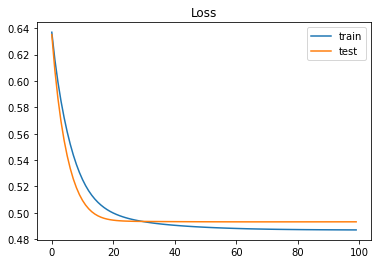

In [7]:
model = Net(2,80,1)
model.to(device)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.BCELoss()

history = train(model, data, epochs=100)
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.show()

In [8]:
# There has to be a better way to convert numpy array to pytorch dataset with minibatches???

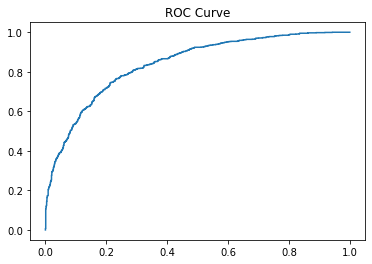

ROC AUC:  0.84


In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
model.to('cpu')
y_pred = model(torch.from_numpy(np.float32(data[2]))).detach()
fpr, tpr, thresholds = roc_curve(data[3], y_pred)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.show()
print("ROC AUC: ", round(roc_auc_score(data[3], y_pred),4))